# Resonance Challenge

The purpose of this challenge is for you to create an RBM to model resonances state in nuclei. Bellow you will find the code to generate the high fidelity solution for protons inside a Woods-Saxon potential with a Coulomb and centrigual barrier. The reduced basis emulator should be built in such a way that it exploits a reference domain, since you will have three distinct regions for your wave function.

Good luck!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import timeit

from scipy.integrate import solve_ivp


In [5]:
def woods_saxon_potential(r, V0, R, a):
    return -V0 / (1 + np.exp((r - R) / a))
def coulomb_pot(Z1,Z2,r,R):
    
    if r>R:
        return  Z1*Z2*1.439/r
    else:
        return Z1*Z2*1.439/(2*R)*(3-(r/R)**2)

def SO(r,R,a,VSO):
    '''Returns the Spin-Orbit Potential (without the l \dot s coupling to be added later)'''
    derivativePart = (-1/a) * np.exp((r-R)/a) / (1+np.exp((r-R)/a))**2
    return VSO * derivativePart / r
    
def coulomb_pot_list(Z1,Z2,r,R):
    if isinstance(r, (int, float)):
        return coulomb_pot(Z1,Z2,r,R)
    else:
        return np.array([coulomb_pot(Z1,Z2,x,R) for x in r])


def schrodinger_eqn(r, y, E, V0, R, a, l):
    psi, psi_prime = y
    psi_double_prime = (2 * m / hbar**2) * (woods_saxon_potential(r, V0, R, a) + l * (l + 1) / r**2 + coulomb_pot_list(Z1,Z2,r,R)- E) * psi
    return [psi_prime, psi_double_prime]

In [11]:
class potentials:
    def __init__(self):
        self.e2 = 1.439646
        self.hbar = 6.582119E-22

    def WS(self,r,R,a,V0):
        return V0 * 1/(1+np.exp((r-R)/a))
    
    def SO(self,r,R,a,VSO):
        '''Returns the Spin-Orbit Potential (without the l \dot s coupling to be added later)'''
        derivativePart = (-1/a) * np.exp((r-R)/a) / (1+np.exp((r-R)/a))**2
        return VSO * derivativePart / r
    
    def Coulomb(self,r,rcutoff,z):
        # coul = np.zeros(len(r))
        
        for i, rval in enumerate(r):
            if rval <= rcutoff:
                coul[i] = (z*self.e2/(2*rcutoff))*(3- (r[i]/rcutoff)**2)
            else:
                coul[i] = z*self.e2/(r[i])
        return coul
    
    def centrifugal(self,r,l,hbar22m):
        return hbar22m * l*(l+1)/(r**2)
    
    def calcV(self,r_,j_,l_,n,z,r0,a,rcut,v0,vso,hbar22m,t_z_=1):
        # Emax = params_['hbar22m'] * params_['kmax']**2
        A = n + z
        r0A = r0 * A**(1/3)
        # r_ = np.arange(0,rmax,dr)
        # r_[0] = 10**-3

        # We can also precompute the non-\ell and non-j dependent terms of our potential for both nucleon types
        # pot = potentials()

        if t_z_ == 0:
            preCompV = self.WS(r_,r0A,a,v0)
        else:
            preCompV = self.WS(r_,r0A,a,v0) + self.Coulomb(r_,rcut,z)

        # Compute the rest of the potential for \ell and j dependent terms, add that onto our precomputed V
        V = preCompV + self.SO(r_,r0A,a,vso)* (r0**2) * (j_*(j_+1) - l_*(l_+1) - 0.75) + self.centrifugal(r_,l_,hbar22m)
        return V
    
    def schrodinger_eqn(self,r, y, E, j_,l_,n,z,r0,a,rcut,v0,vso,hbar22m,Z2=20,Z1=1):
        psi, psi_prime = y
        psi_double_prime = self.calcV(r,j_,l_,n,z,r0,a,rcut,v0,vso,hbar22m) * psi / hbar22m
        return [psi_prime, psi_double_prime]

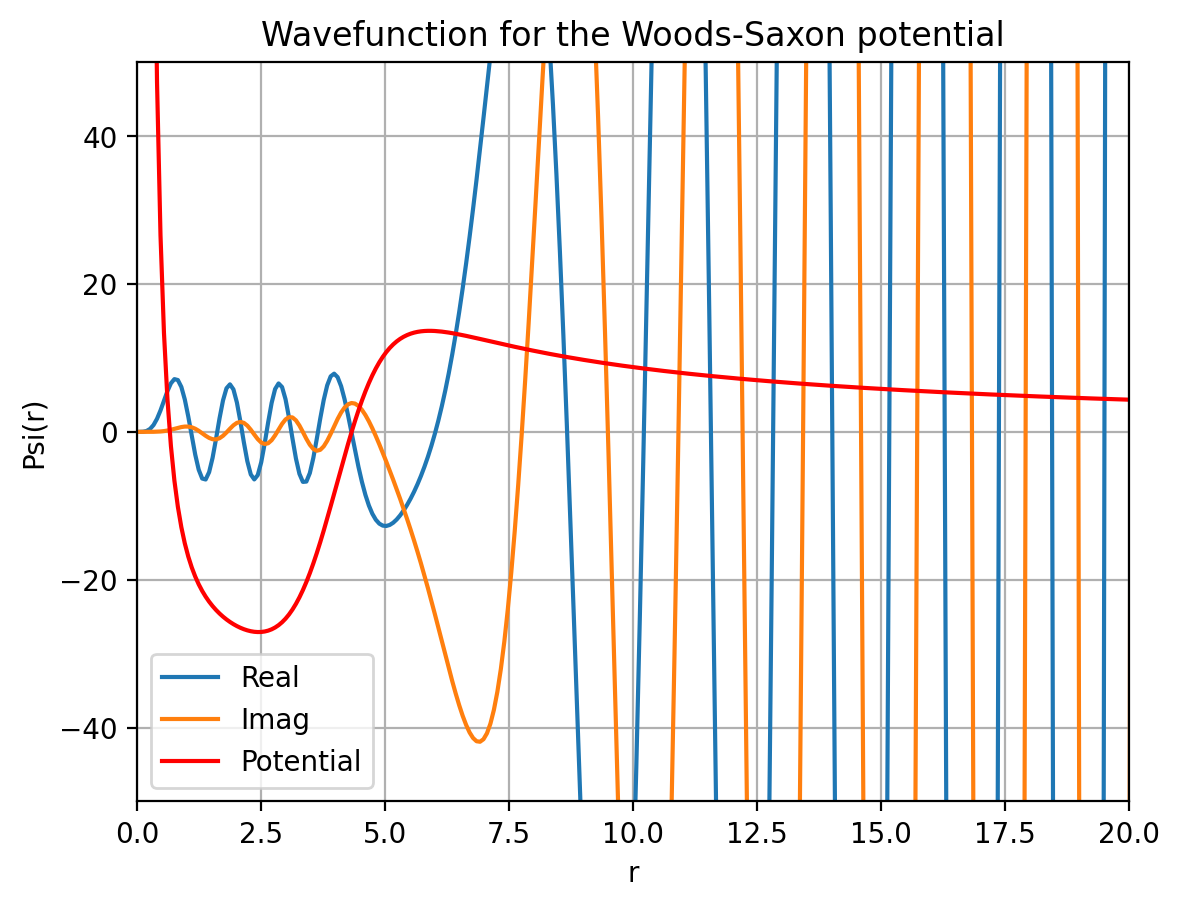

In [12]:
# Constants
Z1=1
Z2=60

eta=Z1*Z2*1.439
m = 1/2  # Particle mass
hbar = 1  # Reduced Planck constant

# Potential parameters
V0 = 60  # Potential strength
R = 4  # Woods-Saxon potential radius
a = 0.5  # Woods-Saxon potential diffuseness

# Energy and angular momentum quantum number
E = 13.4 - 1.3*1j  # Energy eigenvalue
l = 3   # Angular momentum quantum number


# Integration parameters
r_start = 0.05  # Initial position
r_end=70  # Final position

corr_factor=10

# Initial conditions
psi0 = corr_factor*r_start**(l+1) + 0j # Initial wavefunction value
psi_prime0 = corr_factor*(l+1)*r_start**(l) +0j # Initial derivative value

# Solve the Schrödinger equation
sol = solve_ivp(lambda r, y: schrodinger_eqn(r, y, E, V0, R, a, l), (r_start, r_end), [psi0, psi_prime0], dense_output=True)

# Calculate the wavefunction
r_values = np.linspace(r_start, r_end, 1000)
psi_values = sol.sol(r_values)[0]

potvals=(2 * m / hbar**2) * (woods_saxon_potential(r_values, V0, R, a) + l * (l + 1) / r_values**2 + coulomb_pot_list(Z1,Z2,r_values,R))

# Plot the wavefunction
# plt.plot(r_values, 10*np.real(psi_values)/max(abs(psi_values[800:-1])))
# plt.plot(r_values, 10*np.imag(psi_values)/max(abs(psi_values[800:-1])))

fig = plt.figure(dpi=200)
plt.plot(r_values, 10*np.real(psi_values),label='Real')
plt.plot(r_values, 10*np.imag(psi_values),label='Imag')
plt.plot(r_values, potvals,'r',label='Potential')

# plt.plot(r_values, coulomb_pot_list(Z1,Z2,r_values,R),'g')

plt.ylim(-50,50)
plt.xlim(0,20)

plt.legend()

plt.xlabel('r')
plt.ylabel('Psi(r)')
plt.title('Wavefunction for the Woods-Saxon potential')
plt.grid(True)
plt.show()


In [13]:
import matplotlib.cm as cm # Color map

In [14]:
#Rest of the smart code goes here...
def highFidelity(E, V0, VSO, r0, a, l,j, r_start, r_end, psi0, psi_prime0,n=28,z=20,rcut=1.27,hbar22m=20.73553):
    pot = potentials()
    # Solve the Schrödinger equation 
    sol = solve_ivp(lambda r, y: pot.schrodinger_eqn(r, y, E, j,l,n,z,r0,a,rcut,V0,VSO,hbar22m,Z2=20,Z1=1), (r_start, r_end), [psi0, psi_prime0], dense_output=True)

    # Calculate the wavefunction
    r_values = np.linspace(r_start, r_end, 1000)
    psi_values = sol.sol(r_values)[0]

    potvals= pot.calcV(r_values,j,l,n,z,r0,a,rcut,V0,VSO,hbar22m)
    return r_values, psi_values, potvals

# Constants
Z1=1
Z2=20

eta=Z1*Z2*1.439
m = 1/2  # Particle mass
hbar = 1  # Reduced Planck constant

# Potential parameters
V0 = 45.5  # Potential strength
VSO = 19.6666667
R = 3.1  # Woods-Saxon potential radius
a = 0.65  # Woods-Saxon potential diffuseness

# Energy and angular momentum quantum number
E = -20 - 0*1j  # Energy eigenvalue
l = 2   # Angular momentum quantum number
j = 2.5


# Integration parameters
r_start = 0.01  # Initial position
r_end=15  # Final position

corr_factor=10

# Initial conditions
psi0 = corr_factor*r_start**(l+1) + 0j # Initial wavefunction value
psi_prime0 = corr_factor*(l+1)*r_start**(l) +0j # Initial derivative value

E = np.arange(-30,-27,0.005)
cmap = cm.hsv

for i,e_ in enumerate(E):
    r_values, psi_values, potvals = highFidelity(e_, V0,VSO, R, a, l,j, r_start, r_end, psi0, psi_prime0)
    plt.plot(r_values,np.real(psi_values),color=cmap(i/len(E)))

plt.plot(r_values,potvals,color='k')
plt.ylim(-60,30)

TypeError: 'float' object is not iterable